# Problem Statement:

## Predicting speed of the Permanent Magnet Synchronous Motor(PMSM) given other sensor measurements during operation..

# Import necessary libraries

In [1]:
#conda install conda=23.5.0

In [2]:
#pip install tensorflow

In [3]:
#pip install mlxtend

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split,GridSearchCV,KFold,cross_val_score
from sklearn import linear_model
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression,Lasso,Ridge,ElasticNet,RANSACRegressor
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
import statsmodels.api as sm
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from keras.models import Sequential
from keras.layers import Dense


plt.rcParams['figure.figsize']=(16,12)
plt.rcParams['figure.dpi']=250
import warnings
warnings.filterwarnings('ignore')

# Load Dataset

In [2]:
em=pd.read_csv("temperature_data.csv")
em.head(10)

,ambient,coolant,u_d,u_q,motor_speed,torque,i_d,i_q,pm,stator_yoke,stator_tooth,stator_winding,profile_id
0,-0.752143,-1.118446,0.327935,-1.297858,-1.222428,-0.250182,1.029572,-0.245860,-2.522071,-1.831422,-2.066143,-2.018033,4
1,-0.771263,-1.117021,0.329665,-1.297686,-1.222429,-0.249133,1.029509,-0.245832,-2.522418,-1.830969,-2.064859,-2.017631,4
2,-0.782892,-1.116681,0.332771,-1.301822,-1.222428,-0.249431,1.029448,-0.245818,-2.522673,-1.830400,-2.064073,-2.017343,4
3,-0.780935,-1.116764,0.333700,-1.301852,-1.222430,-0.248636,1.032845,-0.246955,-2.521639,-1.830333,-2.063137,-2.017632,4
4,-0.774043,-1.116775,0.335206,-1.303118,-1.222429,-0.248701,1.031807,-0.246610,-2.521900,-1.830498,-2.062795,-2.018145,4
5,-0.762936,-1.116955,0.334901,-1.303017,-1.222429,-0.248197,1.031031,-0.246341,-2.522203,-1.831931,-2.062549,-2.017884,4
6,-0.749228,-1.116170,0.335014,-1.302082,-1.222430,-0.247914,1.030493,-0.246162,-2.522538,-1.833012,-2.062115,-2.017243,4
7,-0.738450,-1.113986,0.336256,-1.305155,-1.222432,-0.248321,1.030107,-0.246035,-2.522844,-1.832182,-2.061953,-2.017213,4
8,-0.730910,-1.111828,0.334905,-1.303790,-1.222431,-0.247785,1.029851,-0.245981,-2.522808,-1.831576,-2.062443,-2.017739,4
9,-0.727130,-1.109486,0.335988,-1.305633,-1.222431,-0.248294,1.029636,-0.245888,-2.522677,-1.831438,-2.062317,-2.018180,4


# Correlation

#### Since there is no  proper pattern visible in the plot correlation matrix is used to get the magnitude of the correlations between the features

In [88]:
# for computing correlations
em.corr()

,ambient,coolant,u_d,u_q,motor_speed,torque,i_d,i_q,pm,stator_yoke,stator_tooth,stator_winding,profile_id
ambient,1.000000,0.434435,0.194754,0.087430,0.078283,-0.262264,0.005605,-0.260562,0.501496,0.451616,0.396742,0.301883,0.384565
coolant,0.434435,1.000000,0.178708,0.027851,-0.033332,-0.189617,0.108489,-0.186060,0.430548,0.874037,0.689003,0.509298,0.499669
u_d,0.194754,0.178708,1.000000,-0.027472,-0.233828,-0.821325,0.358517,-0.796586,-0.082564,0.041428,-0.066256,-0.150714,0.300771
u_q,0.087430,0.027851,-0.027472,1.000000,0.716897,-0.037262,-0.181855,-0.026348,0.101236,0.106186,0.149017,0.125445,-0.122260
motor_speed,0.078283,-0.033332,-0.233828,0.716897,1.000000,0.024517,-0.722914,0.006323,0.332419,0.182564,0.333909,0.393154,-0.166225
torque,-0.262264,-0.189617,-0.821325,-0.037262,0.024517,1.000000,-0.239059,0.996560,-0.072905,-0.092207,-0.011055,0.080981,-0.257446
i_d,0.005605,0.108489,0.358517,-0.181855,-0.722914,-0.239059,1.000000,-0.204230,-0.299227,-0.179903,-0.387712,-0.539924,0.142368
i_q,-0.260562,-0.186060,-0.796586,-0.026348,0.006323,0.996560,-0.204230,1.000000,-0.086486,-0.098753,-0.025191,0.060949,-0.256127
pm,0.501496,0.430548,-0.082564,0.101236,0.332419,-0.072905,-0.299227,-0.086486,1.000000,0.695014,0.768352,0.729561,0.156735
stator_yoke,0.451616,0.874037,0.041428,0.106186,0.182564,-0.092207,-0.179903,-0.098753,0.695014,1.000000,0.949898,0.845144,0.398021


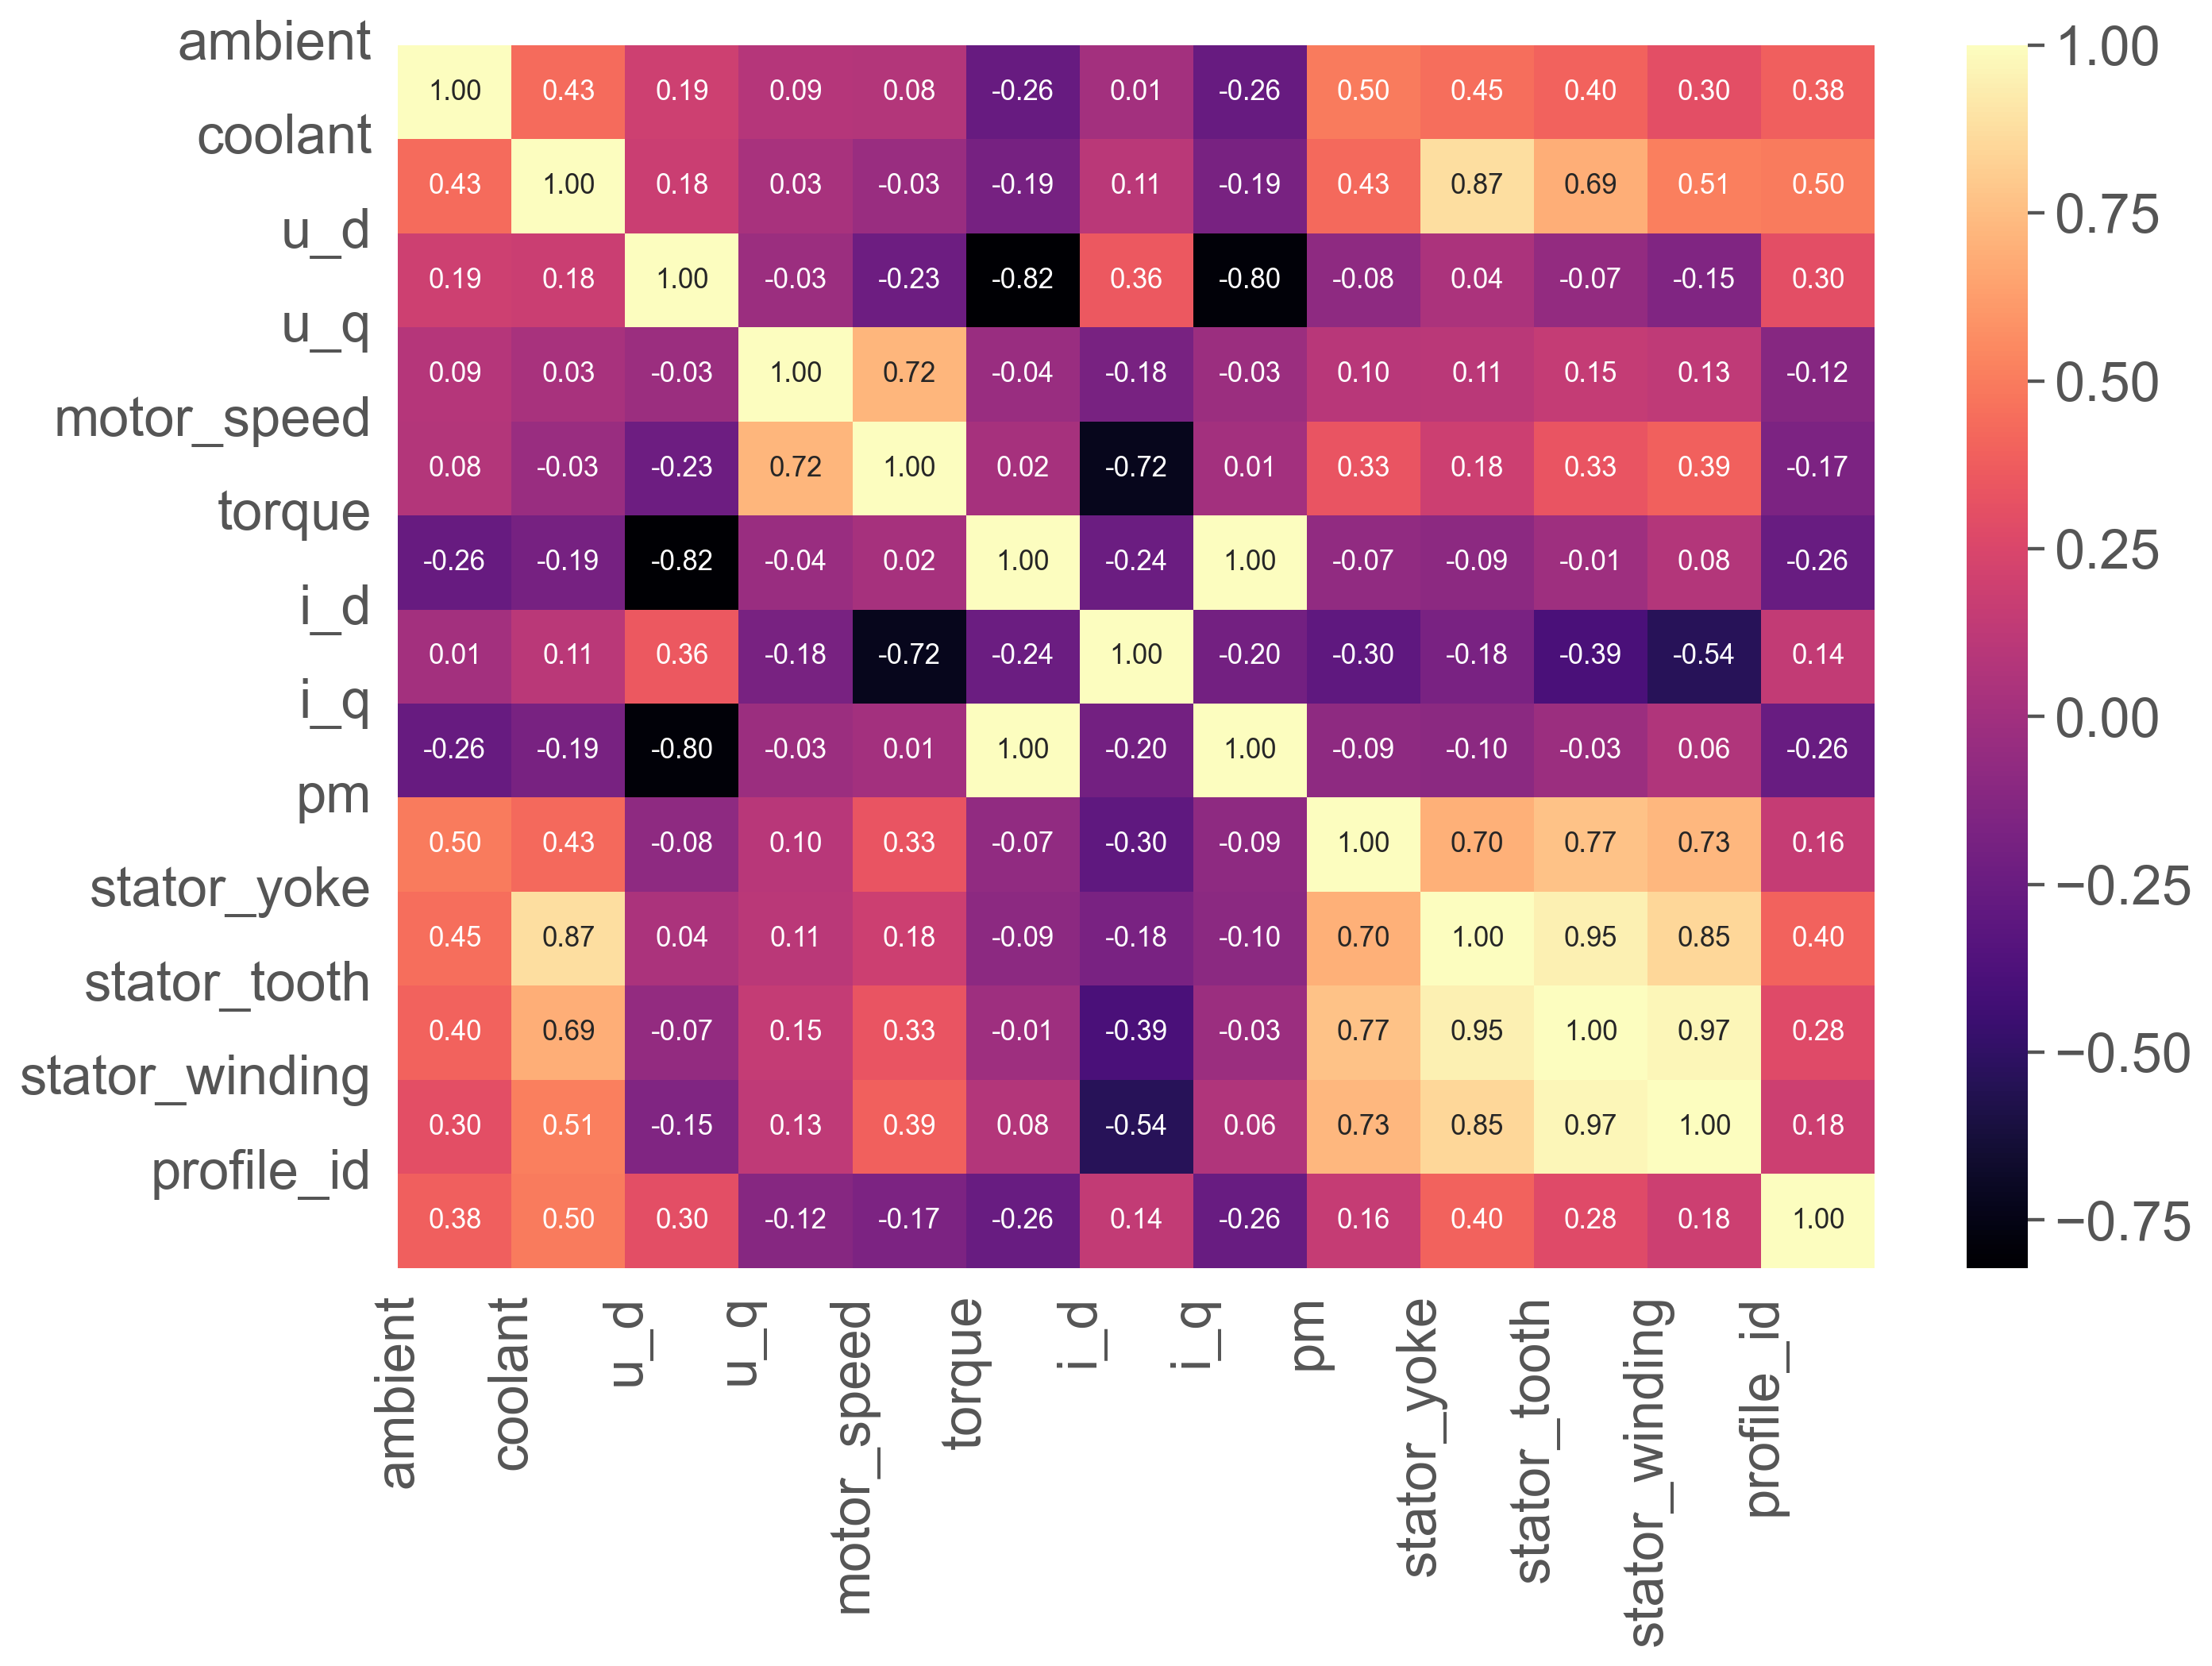

In [89]:
corr = em.corr()
#Plot figsize
fig, ax = plt.subplots(figsize=(12, 8))
#Generate Heat Map, allow annotations and place floats in map
sns.heatmap(corr, cmap='magma', annot=True, fmt=".2f")
#Apply xticks
plt.xticks(range(len(corr.columns)), corr.columns);
#Apply yticks
plt.yticks(range(len(corr.columns)), corr.columns)
#show plot
plt.show()

### Observations:

There is no significant relation between the dependent and the idpendent variables except u_q and i_d

u_q is positively correlated with the motorspeed while i_d is affecting negatively

## Univariate plots

### To check the distribution of data

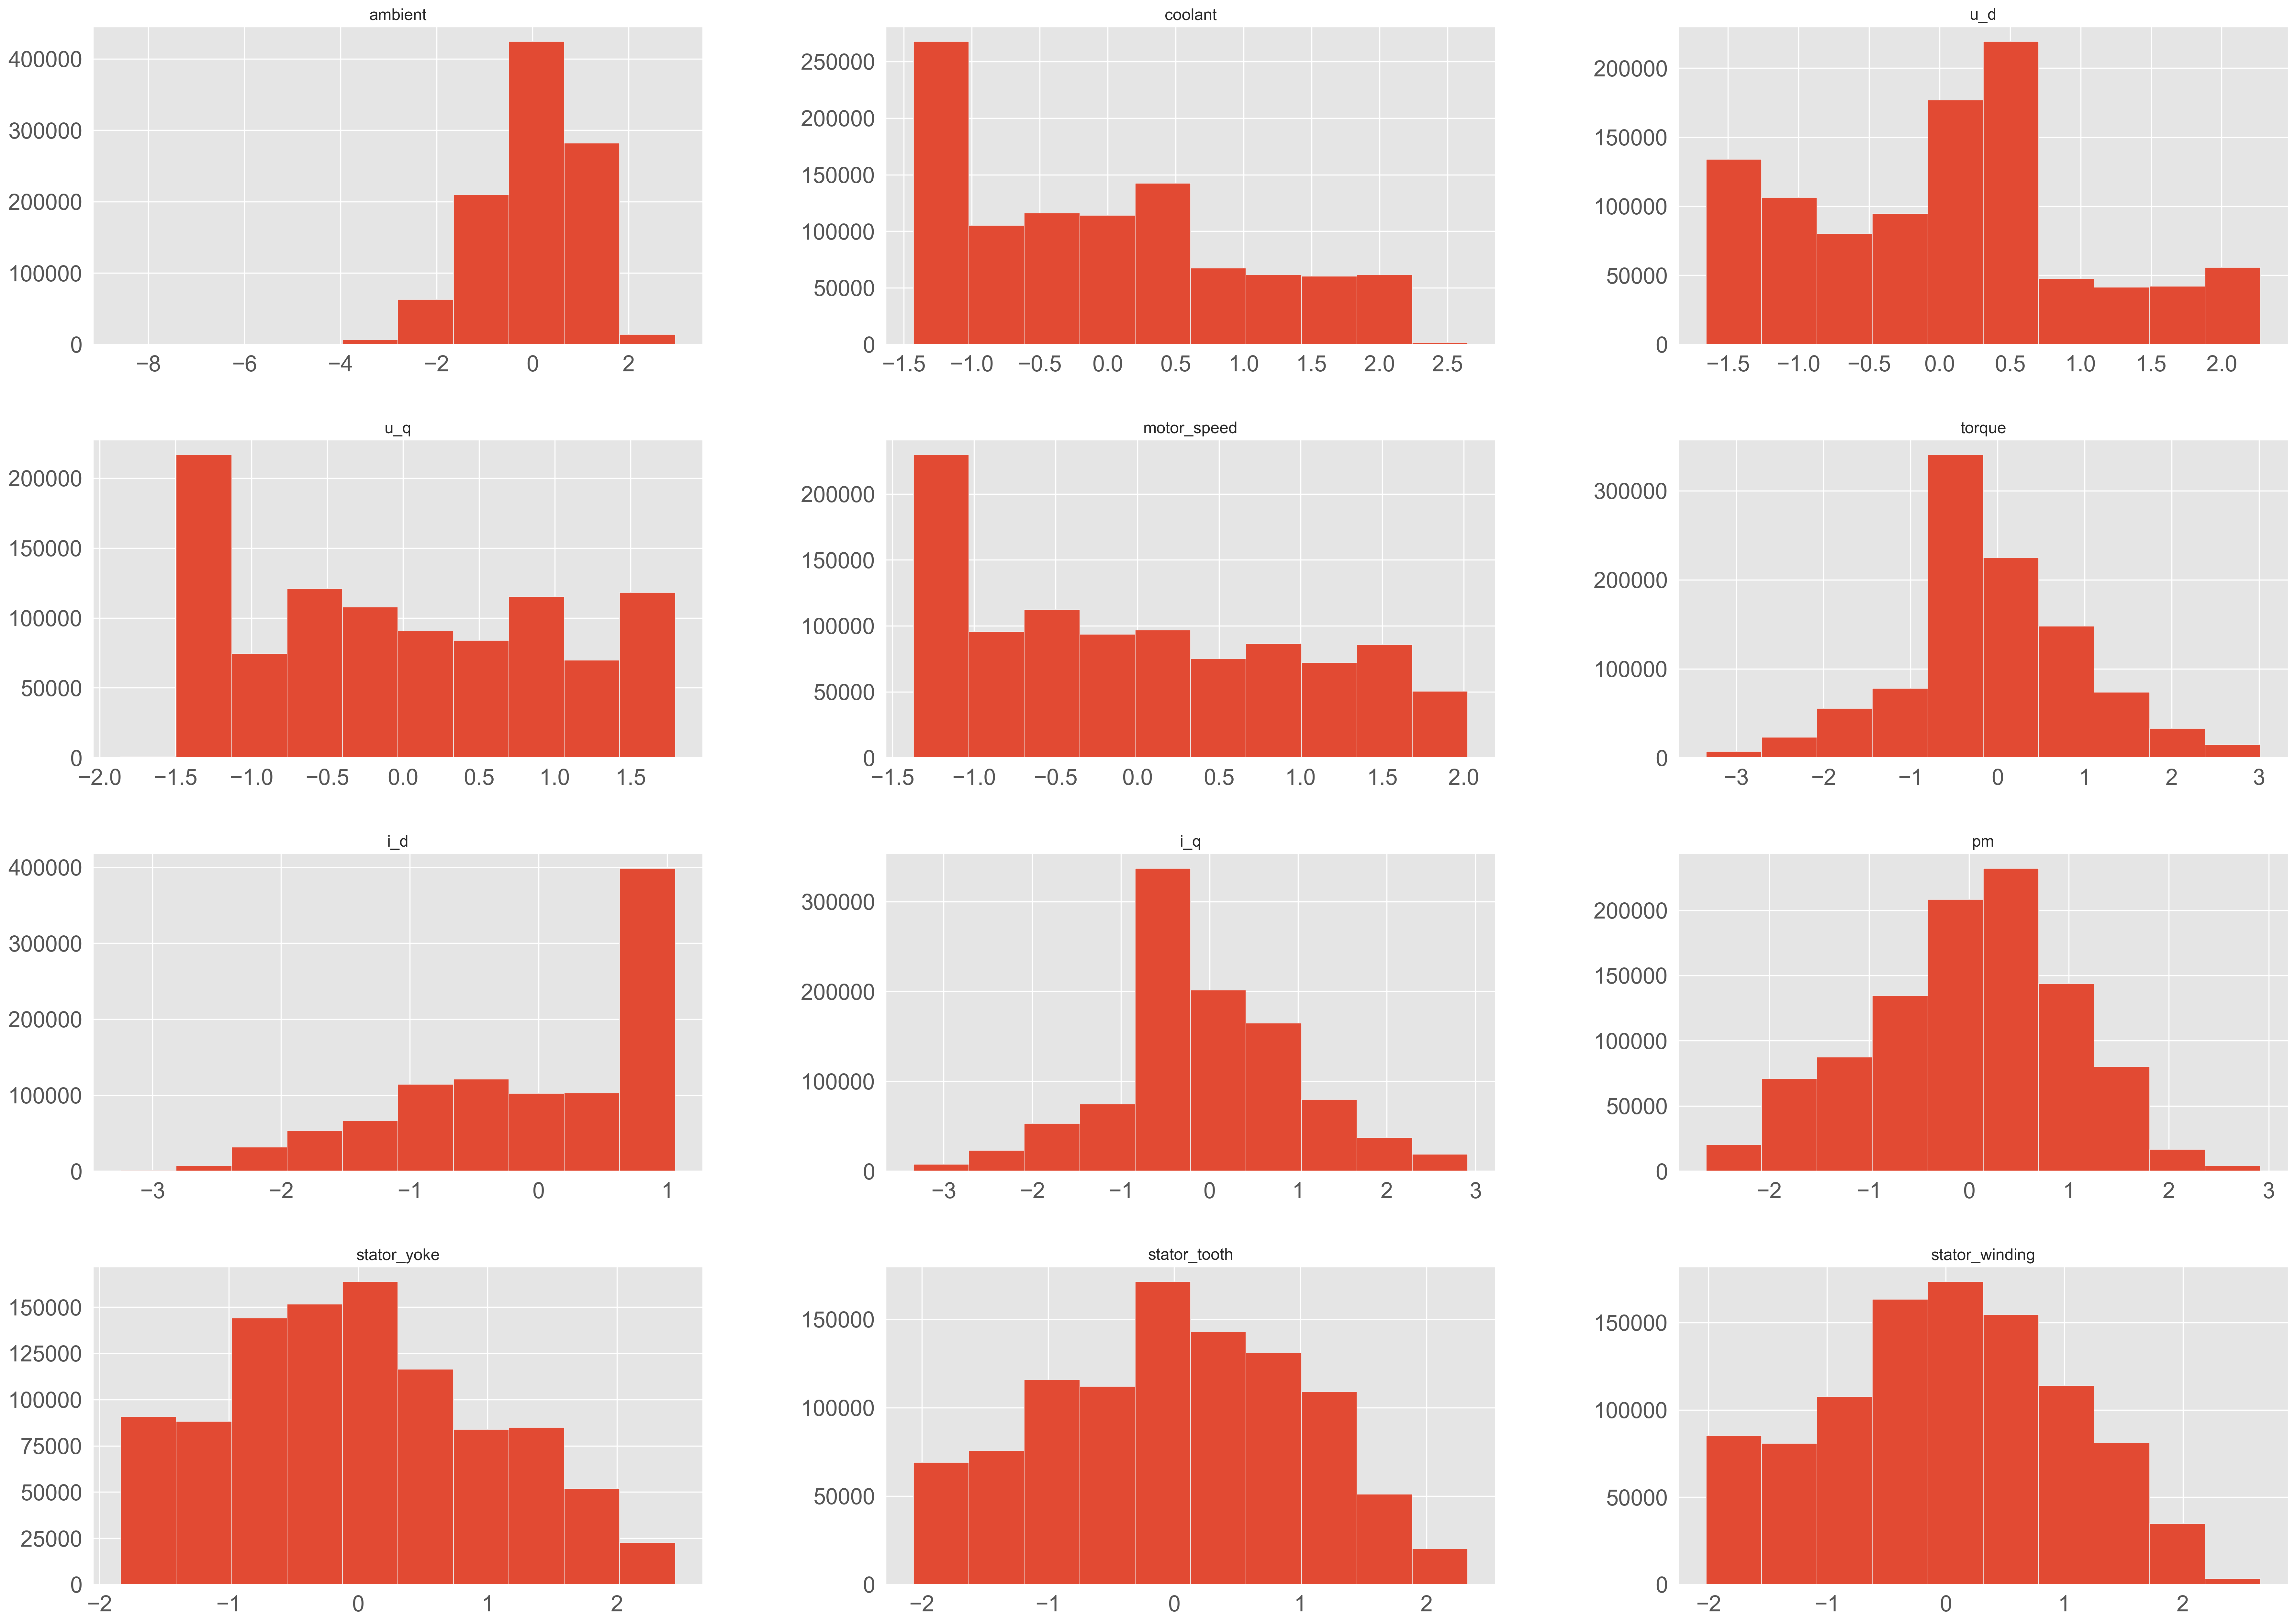

In [90]:
em.iloc[:,:-1].hist(figsize = (35,25))
plt.show()

In [91]:
#sns.distplot(np.sqrt(em['motor_speed']))

ValueError: could not convert string to float: 'profile_id'

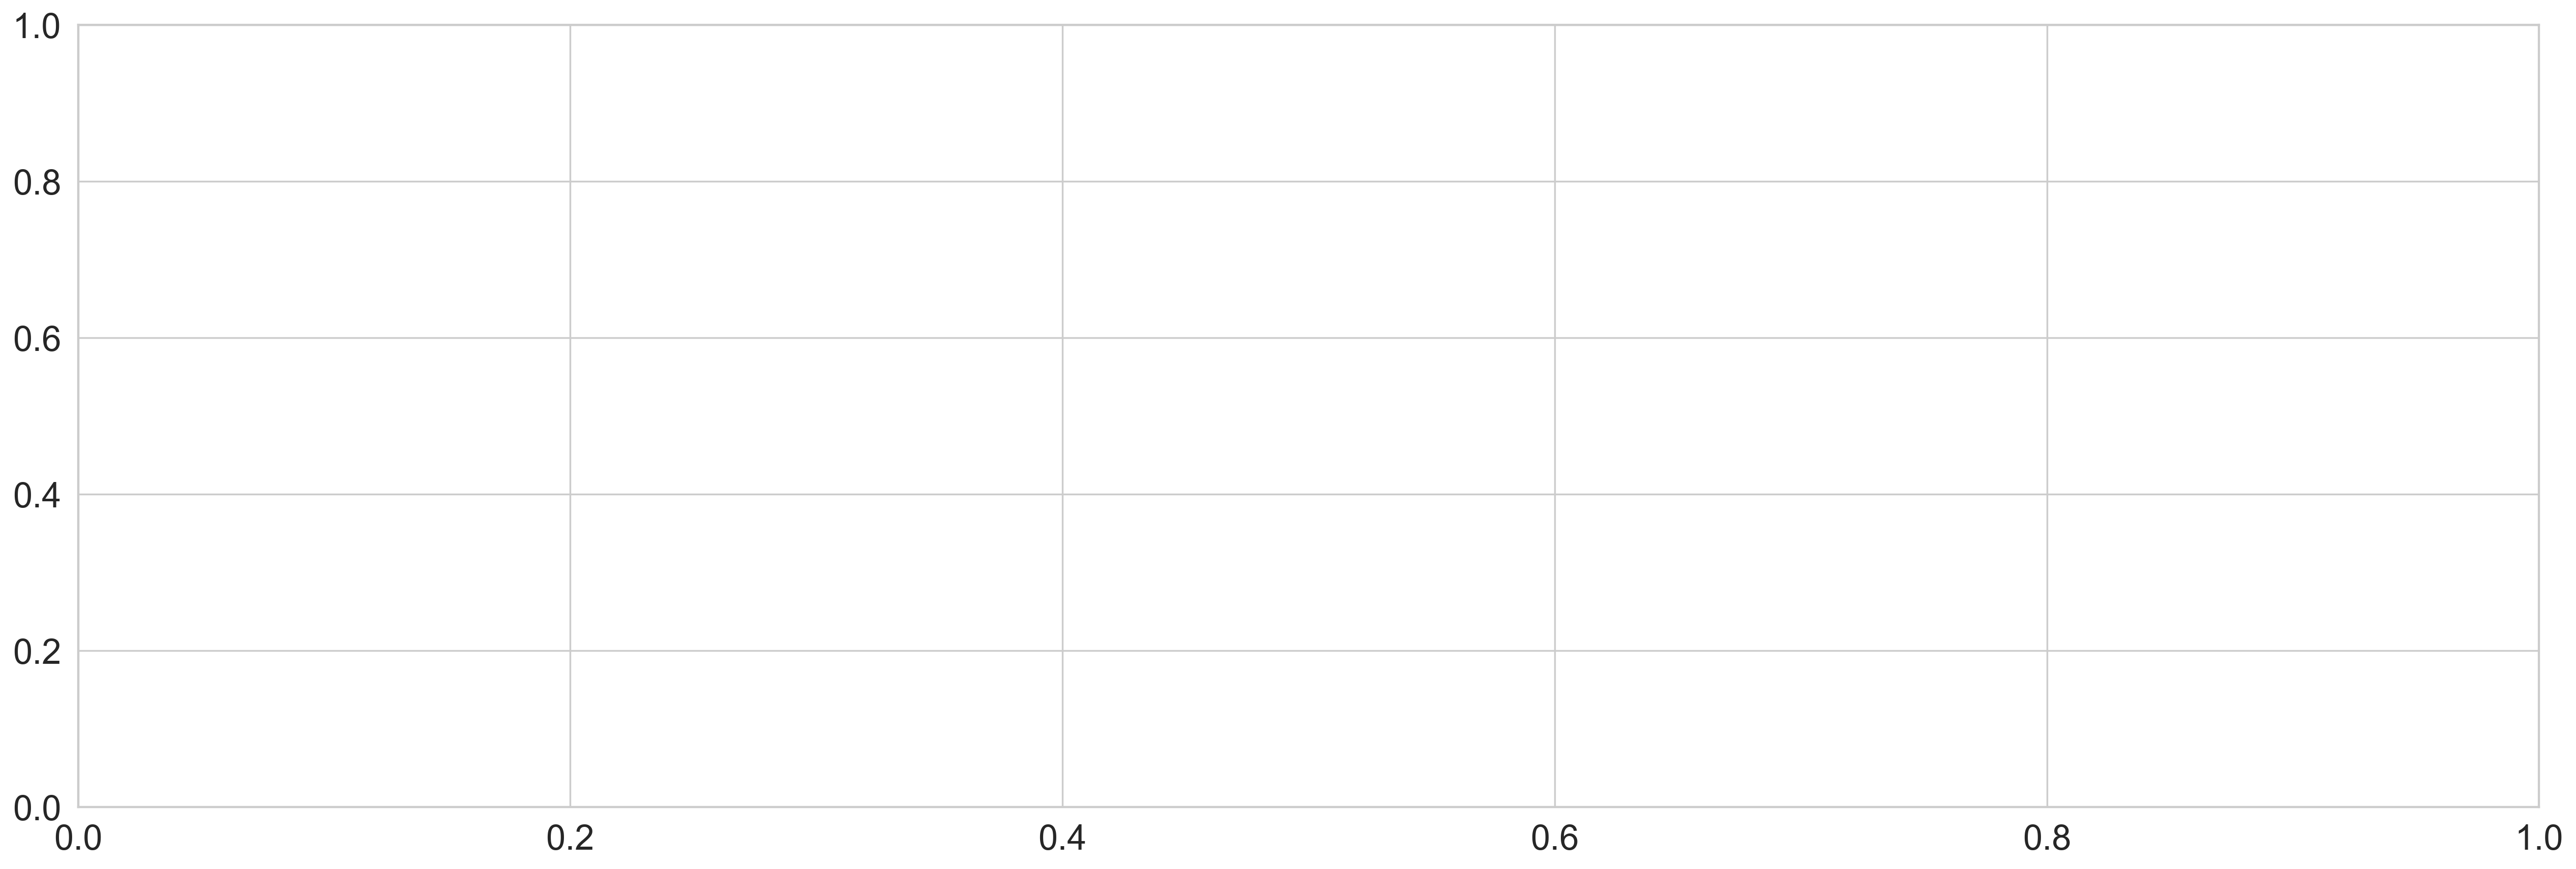

In [92]:
sns.set(style="whitegrid", font_scale=1.8)
plt.subplots(figsize = (25,8))
sns.countplot('profile_id').set_title('count of profile_id')
plt.show()
